#  Medical Imaging
##  Practical session 3
### Image Processing: Image Enhancement and Filtering
### 10th of November 2025
***
**Sebastian Amador Sanchez (sebastian.amador.sanchez@vub.be), Anass Hamdi (anass.hamdi@vub.be), Jef Vandemeulebroucke\
Department of Electronics and Informatics (ETRO)\
Vrije Universitet Brussel, Pleinlaan 2, B-1050 Brussels, Belgium**

## Instructions
The jupyter notebook should be submitted as the report by teams of two using the assignment functionality of Ufora.

Please complete this notebook and upload one of the following before the deadline **November 23, 2025, at 23:59**:
- the executed notebook in *.ipynb* format
- the executed notebook in *.html* format (File --> Download As --> HTML)

The report should contain python code and plotted figures. For this practical session, **we do not** require a separate written report in *.pdf* format.

## Introduction
This exercise session aims to gain insight into the image enhancement and filtering operations commonly applied in medical image processing. You are expected to obtain enhanced and noise-free images at the end of this session.

For more information on the following concepts, see the lecture recordings, course slides, and the related study material.


### BraTS dataset
You will be working with images from the [*Brain Tumor Segmentation (BRATS) Challenge*](http://www.braintumorsegmentation.org), which contains scans of multiple glioma cases. Gliomas are a type of brain tumor originating in the glial cells surrounding the neurons. They are characterized by having various heterogeneous histological subregions. Therefore, they have varying intensity profiles, and multimodal MRI scans must be employed to visualize them properly.

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/brats.png?raw=1" alt="drawing" width="800"/><figcaption><center>**Figure 1:** **(A)** Whole tumor visible in T2-FLAIR **(B)** Tumor core visible in T2 **(C)** Tumor (blue) and necrotic component (green) visible in T1-Contrast **(D)** Tumor sub-regions.</center></figcaption></td>

You DO NOT have to download the dataset; the images that you will employ are included in this practical session. These images were artificially corrupted so that you can apply enhancing and denoising techniques.

### Required modules
Before starting make sure you have installed the following libraries:

- ```SimpleITK``` -> Read and write medical images
- ```numpy``` -> Operation with arrays
- ```matplotlib``` -> Plot images
- ```skimage``` -> Filtering

## Grading
There are a total of three exercises to complete in this practical session. The table below provides a break-down of the points assigned to each exercise.

|              | Coding & Figures |
|--------------|------------------|
| Exercise 1   |         3        |
| Exercise 2.1 |         3        |
| Exercise 2.2 |         4        |

#### Questions:  [sebastian.amador.sanchez@vub.be](mailto:sebastian.amador.sanchez@vub.be), [anass.hamdi@vub.be](mailto:anass.hamdi@vub.be)

# 1. Image Enhancement
## 1.1 The image histogram
The histogram represents how many pixels have a certain intensity in the corresponding image. In image processing, it facilitates the identification of image acquisition issues, for example:

- **Over and under exposure:** Are intensity values spread out (good) or clustered (bad)?

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/hist_exposure.png?raw=1" alt="drawing" width="800"/>

- **Contrast:** Are there many distinct intensity values (high contrast), or does the image use few intensity values (low contrast)? A "normal" contrast is when intensity values are widely spread, with a significant difference between min and max intensity values.

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/hist_contrast.png?raw=1" alt="drawing" width="800"/>

- **Dynamic range:** Related to the number of distinct pixels in the image.

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/hist_dyn_range.png?raw=1" alt="drawing" width="800"/>

Unlike previous examples, medical images can have a large intensity range or even floating point intensities. This yields very large histograms and makes the pixel count per intensity impractical.

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/hist_mri.png?raw=1" alt="drawing" width="600"/>

Therefore, in practice, intensities are usually binned, i.e. grouped in a reduced number of bins with similar intensity.

## 1.2 Image enhancement

We shall discuss three ways of contrast improvement:

1. [Linear contrast mapping](http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm) or histogram stretching. It involves a linear transformation on the image intensities, such that the transformed intensities cover to the full range.
2. [Histogram equalisation](https://homepages.inf.ed.ac.uk/rbf/HIPR2/histeq.htm). In this case, the aim is to obtain a uniform histogram, in which all intensities are equally represented. This can be done by applying a nonlinear transformation on the image intensities.
3. [CLAHE](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html). Contrast Limiting Adaptive Histogram Enhancement (CLAHE) solves the resultant noise from applying histogram equalization. Instead of executing the equalization in a "global" manner, CLAHE applies histogram equalization in small patches taken from the image.

## Exercise 1.

**Important: Both the image and the ground-truth segmentation are 3D volumes. To visualize them with Matplotlib, you’ll need to extract a 2D slice from the 3D array by selecting an index along one axis. The first NumPy array axis is a good choice, as it corresponds to the transverse (axial) plane, providing a global overview of the brain. However, the choice of axis is up to you.**

- Start by reading the image "T1.nii.gz" from the folder "Images" with the command [```ReadImage(path_to_image)```](https://simpleitk.readthedocs.io/en/master/IO.html). ```SimpleITK``` returns an ITK image that you will have to convert to an array before using any other non SimpleITK related python functions; for example, ```plt.imshow(image)``` or ```plt.hist(image, bins)```.
- To visualize the image, first convert it to an array using ```sitk.GetArrayFromImage(image)```. Next, employ [```plt.imshow(array)```](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html) to show the image. **Don't forget to slice the 3D array into a 2D array before using matplotlib!**
- Afterwards, use [```plt.hist(image, bins)```](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html) from ```matplotlib``` with ```bins=35``` to view the histogram.
- You may notice that the histogram is unclear due to the large number of background voxels. To address this, load the mask image "Mask.nii.gz" from the "Images" folder in the same way you loaded "T1.nii.gz". This mask is a binary image that you can use to select only the foreground voxels from your original and enhanced T1 images. For efficiency, it’s best to flatten both the T1 images and the mask before indexing.


### Exercise 1.1: Linear contrast mapping
Write a function that performs linear histogram stretching (see course slides) between 0 and 1. Look at the result and its histogram with bins set to ```35``` (without background voxels using "Mask.nii.gz" see above). Compare with the histogram of the original. To built the function:
1. Instead of using the minimum and maximum intensity values of the image, employ the P5 and P95 percentiles of the image array using [```np.percentile```](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html).
2. Use [```np.clip```](https://numpy.org/doc/stable/reference/generated/numpy.clip.html) to limit the image intensities between the P5 and P95 percentiles.
3. Apply the linear stretching transformation to the clip image using the percentile values as min and max intensities (P5 and P95 respectively).


### Exercise 1.2: Histogram equalization
Implement histogram equalization to the original image. To create the equalized histogram:
1. Get the original histogram and the respective bin edges employing ```np.histogram``` and a number of bins equal to 35. You will have to apply ```.ravel()``` to the image array to correctly obtain the values.
2. Calculate the center of the bin edges.
3. Determine the cumulative histogram using [```.cumsum()```](https://numpy.org/devdocs/reference/generated/numpy.cumsum.html)
4. Re-scale the cumulative histogram between 0 and 1 by dividing with the max value of the cumulative histogram.
5. Use [```np.interp()```](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) to map the original pixel values to their new distribution. Since ```np.interp()``` is a one-dimensional linear interpolation, flat the original image array using [```flat```](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flat.html).  Additionally, use the center of the bin edges as the x-coordinates and the re-scaled cumulative histogram as the y-coordinates.
6. Since the output of point 5 is a 1D-array, reshape it to the original size using [```.reshape(shape)```](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

Compare your equalized image with the one obtained by using [CLAHE](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist). To use CLAHE, you will have to first rescale "T1.nii.gz" between 0 and 1:
- Use the function [```sitk.RescaleIntensity()```](https://simpleitk.org/doxygen/latest/html/namespaceitk_1_1simple.html#af34ebbd0c41ae0d0a7a152ac1382bac6), setting ```outputMinimum=0``` and ```outputMaximum=1```

## Report
<font color=blue>

- Show a four-by-two image comparison (use ```subplots```). Display the original MRI image, the linear stretched, the histogram equalized, the CLAHE, and their corresponding histograms. **Do not forget to use the mask image for the histogram plots!** (3 points)
    
    
</font>

<font color=blue> Your answer here </font>

In [5]:
# Import packages
!git clone https://github.com/noco04-ugent/Practicum_3
!pip install SimpleITK
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage import exposure

Cloning into 'Practicum_3'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 28 (delta 0), reused 1 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (28/28), 89.28 MiB | 23.85 MiB/s, done.


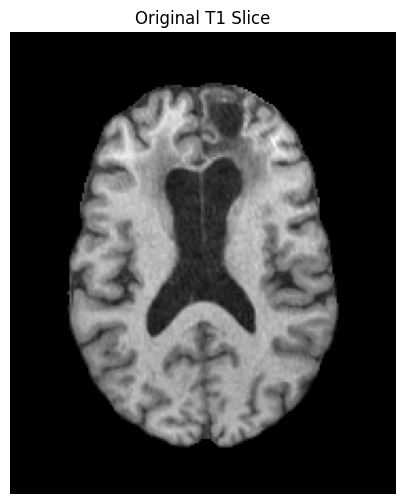

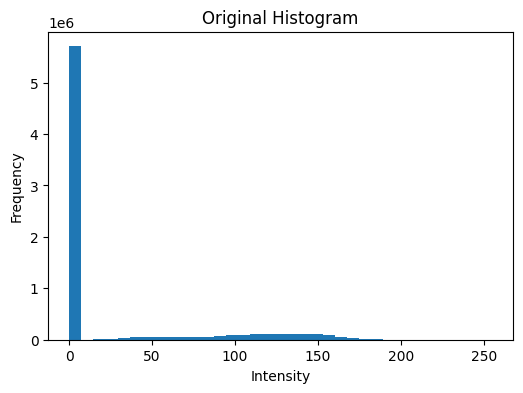

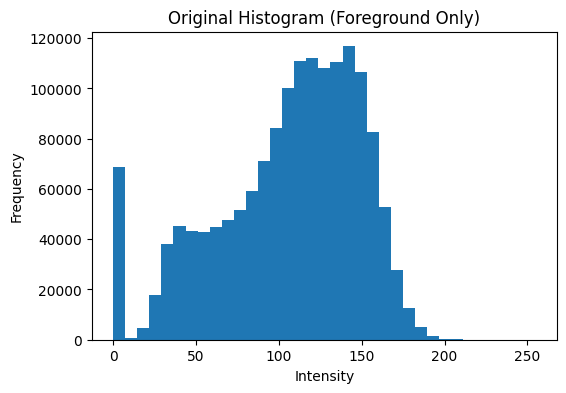

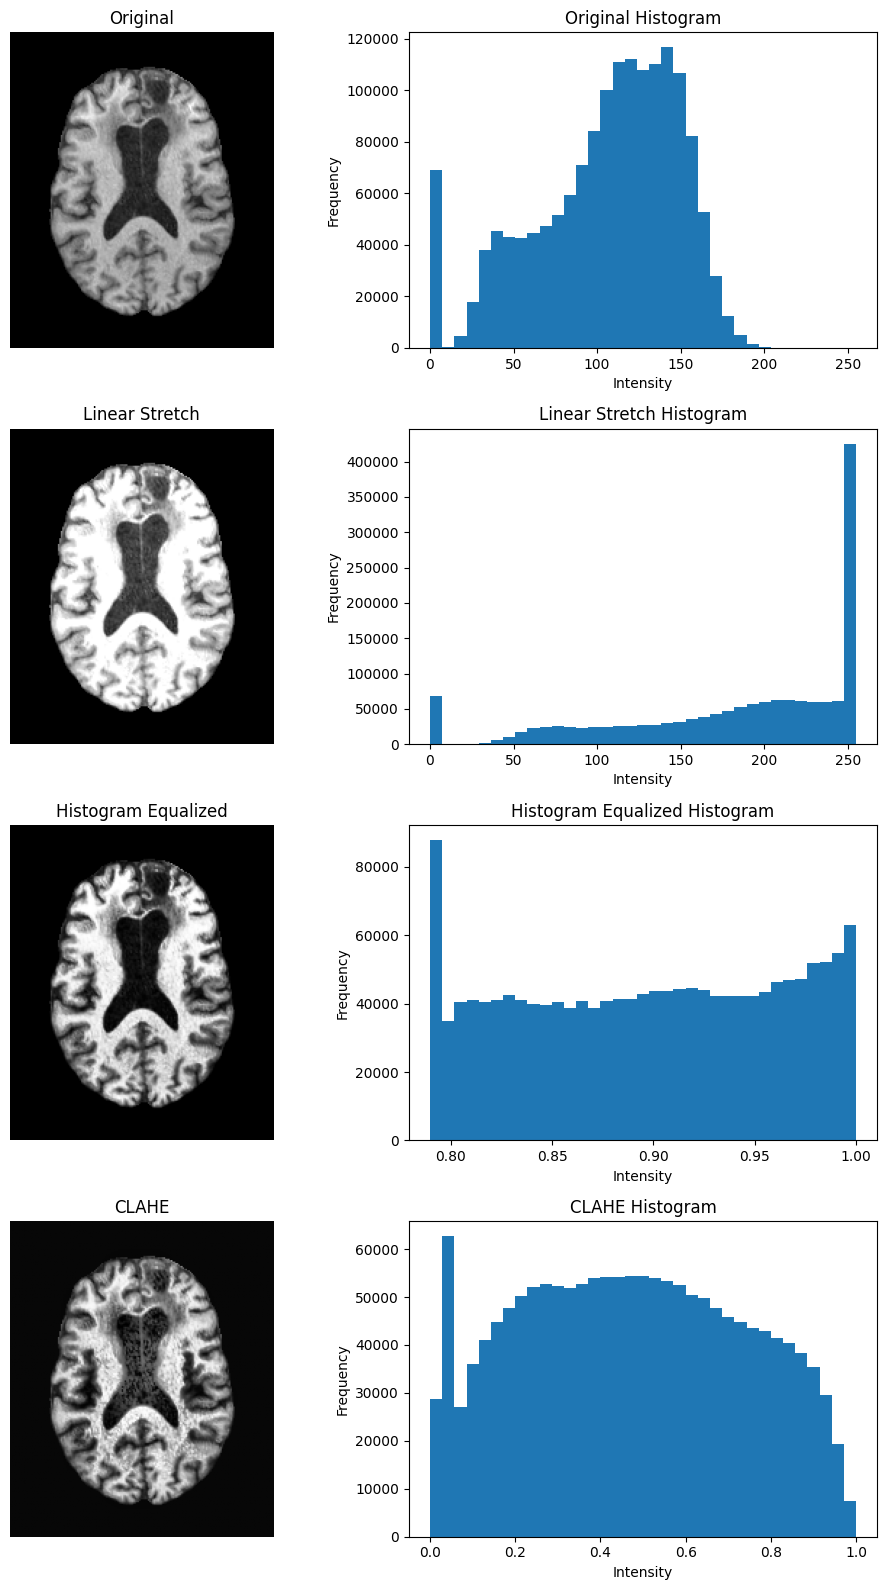

In [17]:
# your code here

# --- 1. Load and convert images ---

# Paths to the images (adjust if needed)
path_T1 = "/content/Practicum_3/Images/T1.nii.gz"
path_mask = "/content/Practicum_3/Images/Mask.nii.gz"

# Read images using SimpleITK
img_T1 = sitk.ReadImage(path_T1)
img_mask = sitk.ReadImage(path_mask)

# Convert to NumPy arrays
arr_T1 = sitk.GetArrayFromImage(img_T1)      # 3D array
arr_mask = sitk.GetArrayFromImage(img_mask)  # 3D mask (binary)

# Select a slice for visualization (choose any index you prefer)
slice_idx = arr_T1.shape[0] // 2  # middle slice
img_slice = arr_T1[slice_idx, :, :]
mask_slice = arr_mask[slice_idx, :, :]

# --- 2. Visualize original image ---
plt.figure(figsize=(6, 6))
plt.imshow(img_slice, cmap='gray')
plt.title("Original T1 Slice")
plt.axis('off')
plt.show()

# --- 3. Histogram  ---
T1_flat = arr_T1.flatten()

plt.figure(figsize=(6, 4))
plt.hist(T1_flat, bins=35)
plt.title("Original Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Flatten and mask (foreground pixels/voxels only)
mask_flat = arr_mask.flatten().astype(bool)
T1_foreground = T1_flat[mask_flat]

plt.figure(figsize=(6, 4))
plt.hist(T1_foreground, bins=35)
plt.title("Original Histogram (Foreground Only)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# --- 4. Linear Contrast Stretching (P5 - P95) ---
def linear_contrast_stretch(image, p_low=5, p_high=95):
    p5, p95 = np.percentile(image, (p_low, p_high))
    image_clipped = np.clip(image, p5, p95)
    stretched = (image_clipped - p5) / (p95 - p5) * 255 ##### Is this factor needed?
    return stretched

arr_linear = linear_contrast_stretch(arr_T1)

# --- 5. Histogram Equalization ---
def histogram_equalization(image, bins=35):
    hist, bin_edges = np.histogram(image.ravel(), bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf[-1]
    image_eq = np.interp(image.flat, bin_centers, cdf_normalized)
    return image_eq.reshape(image.shape)

arr_equalized = histogram_equalization(arr_T1)

# --- 6. CLAHE (Contrast Limited Adaptive Histogram Equalization) ---
# First, rescale image between 0 and 1 using SimpleITK
img_rescaled = sitk.RescaleIntensity(img_T1, outputMinimum=0.0, outputMaximum=1.0)
arr_rescaled = sitk.GetArrayFromImage(img_rescaled)
arr_clahe = exposure.equalize_adapthist(arr_rescaled, clip_limit=0.03)

# --- 7. Prepare histograms (mask foreground only) ---
def masked_histogram(array, mask, bins=35):
    arr_flat = array.flatten()
    mask_flat = mask.flatten().astype(bool)
    return arr_flat[mask_flat]

h_orig = masked_histogram(arr_T1, arr_mask)
h_linear = masked_histogram(arr_linear, arr_mask)
h_equal = masked_histogram(arr_equalized, arr_mask)
h_clahe = masked_histogram(arr_clahe, arr_mask)

# --- 8. Visualization: 4x2 Subplots ---
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

titles = ["Original (Foreground only)", "Linear Stretch (Foreground only)", "Histogram Equalized (Foreground only)", "CLAHE (Foreground only)"]
images = [arr_T1, arr_linear, arr_equalized, arr_clahe]
histograms = [h_orig, h_linear, h_equal, h_clahe]

for i in range(4):
    # Show image slice
    axes[i, 0].imshow(images[i][slice_idx, :, :], cmap='gray')
    axes[i, 0].set_title(titles[i])
    axes[i, 0].axis('off')

    # Show histogram
    axes[i, 1].hist(histograms[i], bins=35)
    axes[i, 1].set_title(f"{titles[i]} Histogram")
    axes[i, 1].set_xlabel("Intensity")
    axes[i, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()



# 2. Image Denoising

Acquiring an image is always prone to artifacts that may corrupt or degrade its quality. Examples of them are noise, blurring, and distortion. Multiple image restoration filters have been proposed in medical imaging to reduce the effect of these artifacts. Image filters may be used either to improve the image quality before reviewing it or as a pre-processing step to improve the result of further image processing operations such as segmentation.

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/denoising.png?raw=1" alt="drawing" width="500"/>

## 2.1 Noise suppression.

Image noise can often be assumed to be a high-frequency signal. Therefore, many noise reduction approaches filter the high-frequency components while preserving the low-frequency ones; a typical example is the 2D-Gaussian filter.

Despite the wide use of low-pass filtering, this technique has the side effect of blurring the edges of the image. To avoid it, smoothing filters that preserve the edges, such as the non-linear median filter, have been proposed.

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/noise_removal.png?raw=1" alt="drawing" width="700"/>

## 2.2 Edge enhancement
The goal is to enhance the edge contrast of an image in an attempt to improve its apparent sharpness. The resultant edge-image can be added to the original image to enhance the visual quality or be employed as input in an image segmentation approach.

<img src="https://github.com/noco04-ugent/Practicum_3/blob/master/Figures/edge_enhancement.png?raw=1" alt="drawing" width="700"/>

## Exercise 2.1

To illustrate image filtering, you will restore an image which has been distorted with "Salt and Pepper" noise.

1. Read the ground truth image 'T2.nii.gz' and its noisy version 'SP.nii.gz'.
2. Apply [Gaussian filtering](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) to the noisy image with standard deviation 1.
3. Calculate the filtered and the remaining noise.
4. Compute the root mean squared error ([RMSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html)) between your filtered image and the ground truth image by comparing voxel intensities.
Convert both 3D images to 1D arrays using .flatten() before calculating the RMSE.
5. Create an edge map of the obtained filtered image using the [prewitt function](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.prewitt).
6. Repeat steps 3 to 5 using:
  - A [median filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html) with kernel size 3.
  - A mean filter with a kernel size of 3x3x3. Use [```np.ones```](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) to create your kernel, and [ndimage.convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html#scipy.ndimage.convolve) to apply the kernel to the image.

## Report
<font color=blue>
    
- Show a three-by-four plot that displays the following for each method (use the same slice index as in your previous exercise): the resultant filtered image, the filtered noise, the noise that remained and the edge map of the filtered image. Additionally, provide all three values for the RMSE between filtered image and the ground truth. (3 points)
</font>

<font color=blue> Your answer here </font>

In [ ]:
# Import libraries
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import prewitt
from scipy import ndimage

from sklearn.metrics import root_mean_squared_error as rmse

In [ ]:
# your code here

## 2.3 Intensity non-uniformity correction

Non-uniform intensity correction is another common task in image denoising. Grayscale inhomogeneities appear in magnetic resonance (MR) images as systematic changes in the local statistical characteristics of tissues. Homomorphic Unsharp Masking (HUM) is applied as a post-processing tool to reduce these intensity effects.

HUM is conceptually straightforward; it can be easily implemented and is very fast. It relies on the assumption that if grayscale inhomogeneities are not present in the image, the mean or median in a local window should match the global mean or median of the overall image. This assumption is approximately true when the filter window is large enough to enclose a representative sample of tissues.

For a detailed implementation see the paper: [*''Optimized Homomorphic Unsharp Masking for MR Grayscale Inhomogeneity Correction'' by Benjamin H. Brinkmann, Armando Manduca and Richard A. Robb, IEEE, 1998*](https://ieeexplore.ieee.org/document/700729)

HUM requires the computation of:
- The global mean value $\mu$ of the corrupted image
- The local mean value $\mu_{i,j}$ within a neighbourhood
- The HUM corrected/ideal value of a pixel is:

$f_{i,j} = g_{i,j} \cdot \frac{\mu}{\mu_{i,j}},$

   where $g_{i,j}$ is the intensity value of the input image (corrupted/observed image).

## Exercise 2.2

Image 'Bias.nii.gz' is a biased corrupted version of 'Flair.nii.gz'. Implement the HUM algorithm in three different ways to compensate for the artifact:

1. Implement the algorithm straightforwardly using a moving window of $20 \times 20 \times 20$ voxels to calculate the local mean. Because of the size of your local window, you will not be able to correct voxels close to the image borders.
2. Involve the voxels at the image borders by prior padding the image and, thus, enlarging the image. Pad the image with zeros using half of your window size. To pad the image, use [```np.pad```](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)
3. In addition to the padding, leave out the voxels belonging to the background by using a global threshold of 5 over the complete image. In other words, do not include the voxels below the threshold in your calculation of the global mean value.

We expect that for each case, you create a function that has the following backbone:
- Calculates the global mean intensity.
- Create a template or target image where to place the corrected values.
- For points 2 and 3: Before creating the template, you will have to pad the bias image with zeros using the half size of your window.
- For point 3: Get the global mean intensity of the padded bias image by globally applying the threshold.
- Iterate over the bias image using the window you set, and apply the HUM equation: $f_{i,j} = g_{i,j} \cdot \frac{\mu}{\mu_{i,j}}$.
- For points 2 and 3: You will have to return to the original image size.


After the bias field is removed, calculate the [normalized-root-mean-squared-error](https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.normalized_root_mse) (NRMSE) and the [structural similarity index](https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.structural_similarity)  (SSIM) to evaluate the performance of the denoising algorithms.


**Remarks:**

- Read the non-bias brain image in '```uint8```' format
- Since you will be padding with zeros, use: $\frac{\mu}{\mu_{i,j} + \varepsilon}$, $\varepsilon = 1^{-6}$
- Make sure the resultant images are in '```uint8```' format
- You may get an overflow warning when computing the global mean intensity for point 3. In that case, cast the variable to an ```int``` and be sure to make the resultant image in '```uint8```' format.

## Report:
<font color=blue>
    
- Plot a one-by-four figure showing the image with bias (Bias.nii.gz) and the three corrected images obtained using the different implementations of the HUM algorithm (use the same slice index as in your previous exercises). Finally, provide the values for the NRMSE and SSIM between the three corrected images and the ground truth (Flair.nii.gz). (4 points)
    
</font>

<font color=blue> Your answer here </font>

In [ ]:
# Import libraries
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import skimage as skimage

from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssim

In [ ]:
# your code here